$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Im}{\mathbf{I}}
  \newcommand{\Ym}{\mathbf{Y}}
$

# Linear Logistic Regression


Previously we discussed least squres to fit on the discrete target for classification.
When dealing with multiple classes, it can cause *masking problem* that one class estimation is masked by other predictions. For instance, when there are three classes such as red, blue, and green, it can wipe out the class prediction for blue by the two other classes.  

Unlike previous classification algorithms, linear regression directly predicts $P(T=k \mid \xv)$, not the class label $k$ with linear model. 
We call this approach as linear **Logistic Regression**. 
The target output is probability values, thus the target output can be continuous value. 
The probablistic outputs helps us to understand the ML model's confidence about the prediction, which is often beneficial. 

We use the linear model for regression to produce the logit values $\kappa$:

$$
\kappa = f(\xv ; \wv) = \Xm \wv.
$$

Thus, to produce probability values, we use a mapping function $h$ to turn the logit values into probability values:

$$
P(T=k \mid \Xm) = h(\Xm \wv) = h(\kappa) = \yv.
$$


(-3, 7)

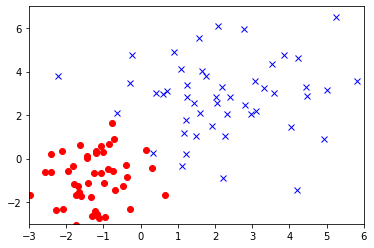

In [2]:
# Toy Data to play with

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

C1 = np.random.multivariate_normal(mu1, cov1, 50)
C2 = np.random.multivariate_normal(mu2, cov2, 50)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])

To classify this data, let us prepare our logistic regression algorithm. First, we will modify the target values to fit and then derive the gradient for the iterative algorithm. 

# Target

To generate multiple probability outputs for each class, we consider the indicator output targets. 

$$
\Tm = \begin{bmatrix}
        t_{1,1} & t_{1,2} & \cdots & t_{1, K} \\
        t_{2,1} & t_{2,2} & \cdots & t_{2, K} \\
        \vdots & & &     \vdots \\
        t_{N,1} & t_{N,2} & \cdots & t_{N, K} \\
      \end{bmatrix}
$$
where $t_{n,k}$ is 0 or 1 with only one 1 per each row. 

Note: Here the weight $\wv$ is not a vector any more. It is matrix with $D+1 \times K$ dimensions. 

You can follow the codes to below to get an idea how to create the indicator matrix.

In [3]:
np.array([0, 1,2,3,2,1]).reshape((-1, 1)) == np.arange(4)

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False]])

In [5]:
(np.array([0, 1,2,3,2,1]).reshape((-1, 1)) == np.arange(4)).astype(int)

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

# Likelihood

Assuming i.i.d (independently identically distributed) data, we can compute the likelihood as

$$
P(\Tm \mid \wv) = \prod_{n=1}^{N} \prod_{k=1}^{K} P(T = k \mid x_n)^{t_{n,k}} = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{n,k}^{t_{n,k}}
$$ 
We read the equation as "when the data is independently distributed, the likelihood is computed by multiplying the conditional probability of the class $k$ given input $x_n$." Remember that $t_{n,k}$ is either zero or one as $\Tm$ is indicator matrix. For each data sample, there are only one $t_{n,k} =$ while the others are zeros. That means, the second expression becomes one mostly for $t_{n,k} = 0$. We predict the $P(T=k \mid x_n)$, and we can say $y_{n,k} = P(T=k \mid x_n)$.

Since we maximize the likelihood function, we define our error function as the negative logarithm of it:

$$
E(\wv) = - \ln P(\Tm \mid \wv) =  - \sum_{n=1}^{N} \sum_{k=1}^{K} t_{n,k} \ln y_{n,k}.
$$

This function is called *cross-entropy* error function for the multiclass classification problem. 



# Gradient Descent

As we practiced in least mean squares, we need to update the weight $\wv$ with the gradient:

$$
\wv \leftarrow \wv - \alpha \nabla_\wv E(\wv).
$$
with the learning rate $\alpha$. 


## Softmax Transformation

Before computing the derivative, let us select the function $h(\cdot)$. 

Since $P(T=k \mid \xv)$ is probability function, it satisfies 

- the outputs are non-negative,

- the integral of the probability is one. 

To ensure this,

$$
P(T=k \mid \xv) = \frac{\kappa_k}{\sum_{c=1}^K \kappa_c}
$$

Since we are working with the logarithm, an exponent is a good idea.

$$
g_k(\xv) = P(T=k \mid \xv) = \frac{e^{\kappa_k}}{\sum_{c=1}^K e^{\kappa_c}}
$$

This function is called as **softmax function**. This generalizes the logistic sigmoid fuunction and the derivatives are given by itself

$$
\frac{\partial g_k}{\partial y_j}  = g_k (I_{kj} - g_j).
$$


## Back to Derivative

Here, the chain rule and knowing the input to the function $g$ is the linear model, we can derive 

$$
\begin{align*}
\nabla_{\wv_j} g_{n,k}(\xv) &= g_k(\xv) (I_{kj} - g_j(\xv)) \nabla_{\wv_j} (\wv^\top \xv) \\
    \\
            &= g_k(\xv) (I_{kj} - g_j(\xv))  \xv.
\end{align*}
$$

Using $\nabla_{\wv_j} g_{n,k}(\xv)$, we can get the gradient as follows:

$$
\begin{align*}
\nabla_{\wv_j} E(\wv) &= \nabla_{\wv_j} \Big(-\sum_{n=1}^{N} \sum_{k=1}^{K} t_{n,k} \ln g_{n,k}(\xv_n) \Big) \\
                      \\
                      &= -\sum_{n=1}^{N} \sum_{k=1}^{K} t_{n,k} \frac{1}{g_{n,k}(\xv_n)} \nabla_{\wv_j} g_{n,k}(\xv_n)\\
                      \\
                      &= -\sum_{n=1}^{N} \sum_{k=1}^{K} t_{n,k} (I_{kj} - g_j(\xv_n)) \xv_n\\
                      \\
                      &= -\sum_{n=1}^{N} \Bigg( \sum_{k=1}^{K} t_{n,k} (I_{kj} - g_j(\xv_n)) \Bigg) \xv_n\\
                      \\
                      &= -\sum_{n=1}^{N} \Bigg( \sum_{k=1}^{K} t_{n,k} I_{kj} - g_j(\xv_n) \sum_{k=1}^{K} t_{n,k} ) \Bigg) \xv_n\\
                      \\
                      &= -\sum_{n=1}^{N} \Bigg(  t_{n,j} - g_j(\xv_n)\Bigg) \xv_n
\end{align*}
$$

Using the gradient, now we can update the weights, 

$$
\wv_j \leftarrow \wv_j + \alpha \sum_{n=1}^{N} \Big( t_{n,j} - g_j(\xv_n)\Big) \xv_n.
$$

Converting the summation into matrix calculation,

$$
\wv_j \leftarrow \wv_j + \alpha \Xm^\top \Big(  t_{*,j} - g_j(\Xm)\Big).
$$


# Implementation 

Before writing codes, let us check the matrix size!

- $\Xm: N \times (D+1)$
- $\Tm: N \times K$


- $\wv: (D+1) \times K$
- $t_{*,j}: N \times 1 $
- $g_j(\Xm): N \times 1 $


- $\Xm^\top \big( t_{*,j} - g_j(\Xm) \big)$: $(D+1) \times N \cdot \big( N \times 1 - N \times 1 \big) \Rightarrow (D+1) \times 1$

This gradient update one column of the weight matrix, so we can combine the computations:

$$
\wv \leftarrow \wv + \alpha \Xm^\top \Big(  \Tm - g(\Xm)\Big).
$$

Double checking the size of matrics,

- $\Xm^\top \big( \Tm - g(\Xm) \big)$: $(D+1) \times N \cdot \big( N \times K - N \times K \big) \Rightarrow (D+1) \times K$. 




# Practice

Read the note and practice codes.
Find TODO comment and finish the following:

- $g(.)$ function,
- the training codes.

In [7]:
# g(.) the softmax function
# TODO: create a g(X ,w) function that compute softmax of linear model 
#.      given the two input X and w

def softmax(z):
    if not isinstance(z, np.ndarray):
        z = np.asarray(z)
    f = np.exp(z) 
    return f / (np.sum(f, axis=1, keepdims=True) if len(z.shape) == 2 else np.sum(f))

# for linear fx
def g(X, w):
    return softmax(X @ w) 

### Toy Data

Now, let us prepare data for training and test data. We will train the model using the training data and apply to the test set to observe the classification accuracy in unseen data.

(-3, 7)

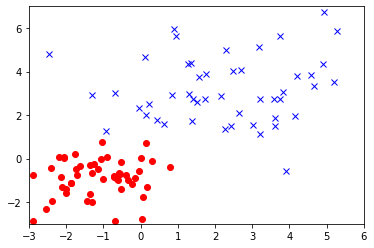

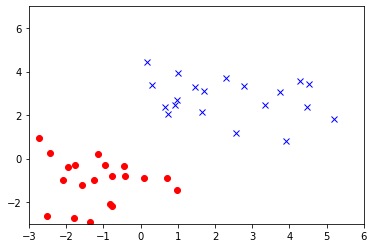

In [8]:
# Data for testing
N1 = 50
N2 = 50
N = N1 + N2
D = 2
K = 2

mu1 = [-1, -1]
cov1 = np.eye(2)

mu2 = [2,3]
cov2 = np.eye(2) * 3

#
#  Train Data
#
C1 = np.random.multivariate_normal(mu1, cov1, N1)
C2 = np.random.multivariate_normal(mu2, cov2, N2)

plt.plot(C1[:, 0], C1[:, 1], 'or')
plt.plot(C2[:, 0], C2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])

Xtrain = np.vstack((C1, C2))
Ttrain = np.zeros((N, 2))
Ttrain[:50, 0] = 1
Ttrain[50:, 1] = 1

means, stds = np.mean(Xtrain, 0), np.std(Xtrain, 0)
# normalize inputs
Xtrains = (Xtrain - means) / stds

#
#  Test Data
#
Ct1 = np.random.multivariate_normal(mu1, cov1, 20)
Ct2 = np.random.multivariate_normal(mu2, cov2, 20)

Xtest = np.vstack((Ct1, Ct2))
Ttest = np.zeros((40, 2))
Ttest[:20, 0] = 1
Ttest[20:, 1] = 1

# normalize inputs
Xtests = (Xtrain - means) / stds


plt.figure()
plt.plot(Ct1[:, 0], Ct1[:, 1], 'or')
plt.plot(Ct2[:, 0], Ct2[:, 1], 'xb')

plt.xlim([-3, 6])
plt.ylim([-3, 7])

**initialization:** We first initialize the weights with random values. The shape of the weight matrix is $D+1 \times k$. 

In [9]:
# TODO: initialize the weight matrix
w = np.random.rand(D+1, K)

**training:** We train the model on training data **(Xtrain, Ttrain)**. 

In [10]:
# iterate to update weights
niter = 1000    # max number of iteration
alpha = 0.1     # learning rate

X1 = np.hstack((np.ones((N, 1)), Xtrain))    # add a bias column
likeli = []

##### Training loop
for step in range(niter):
    # TODO: add training code here! 
    ys = g(X1, w)
    w += alpha * X1.T @ (Ttrain - ys)
    


**test:** We apply the trained model to **Xtest** and compare the prediction with **Ttest**. 

In [11]:
# TODO: apply the model to produce the probability values as the output below   
X1t = np.hstack((np.ones((Xtest.shape[0],1)), Xtest))
Y = g(X1t, w)

Y

array([[1.00000000e+00, 7.20854733e-18],
       [1.00000000e+00, 6.50021226e-20],
       [1.00000000e+00, 6.43247099e-56],
       [1.00000000e+00, 7.50439285e-23],
       [1.00000000e+00, 7.67138666e-35],
       [1.00000000e+00, 7.49702512e-35],
       [1.00000000e+00, 3.21104281e-14],
       [1.00000000e+00, 6.12889730e-13],
       [1.00000000e+00, 2.43180188e-26],
       [1.00000000e+00, 3.83258450e-24],
       [1.00000000e+00, 2.04751843e-25],
       [1.00000000e+00, 3.83565137e-20],
       [1.00000000e+00, 8.29622569e-24],
       [1.00000000e+00, 2.02280748e-42],
       [1.00000000e+00, 3.04645010e-19],
       [1.00000000e+00, 1.05144310e-43],
       [1.00000000e+00, 4.10193484e-58],
       [1.00000000e+00, 5.92998596e-56],
       [1.00000000e+00, 8.06493820e-26],
       [1.00000000e+00, 1.29810260e-30],
       [1.01969278e-25, 1.00000000e+00],
       [3.83801888e-18, 1.00000000e+00],
       [3.60129085e-46, 1.00000000e+00],
       [2.06656676e-20, 1.00000000e+00],
       [5.167015

**Presenting results**: Now we can plot the results and present the accuracy. 

Accuracy:  100.0 %


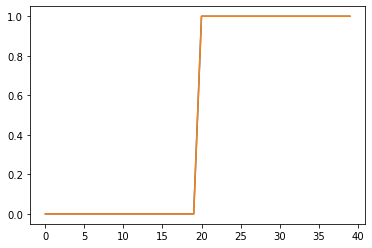

In [12]:
# retrieve labels and plot
Yl = np.argmax(Y, 1)
Tl = np.argmax(Ttest, 1)

plt.plot(Tl)
plt.plot(Yl)

# TODO: compute the accuracy to show the results. 
#.      As the data is randomly generated, the accuracy values can be different in yours. 
print("Accuracy: ", 100 - np.mean(np.abs(Tl - Yl)) * 100, "%")

We can observe the how the decision boundary is formed. As we use a linear model, the decision boundary is a straigh line.

**TODO: (Discussion on Canvas) Read the codes and understand what each line does and share your understanding with class.**

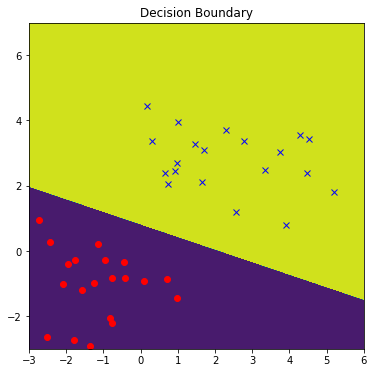

In [13]:
# show me the boundary

x = np.linspace(-3, 6, 1000)
y = np.linspace(-3, 7, 1000)

xs, ys = np.meshgrid(x, y)

X = np.vstack((xs.flat, ys.flat)).T
X1 = np.hstack((np.ones((X.shape[0], 1)), X))

Y = g(X1, w)
zs = np.argmax(Y, 1)

plt.figure(figsize=(6,6))
plt.contourf(xs, ys, zs.reshape(xs.shape))
plt.title("Decision Boundary")

plt.plot(Ct1[:, 0], Ct1[:, 1], 'or')
plt.plot(Ct2[:, 0], Ct2[:, 1], 'xb')
